# Phishing Email Detection Pipeline
A workflow: from data loading and cleaning to TF-IDF, Bag-of-Words.


1. Imports & Setup

In [1]:
import pandas as pd
import numpy as np
import os
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.decomposition import PCA
from sentence_transformers import SentenceTransformer
from tqdm import tqdm
import ast

tqdm.pandas()


2. Load Dataset

Loaded phishing dataset with shape: (2576, 4)
Columns: ['Subject', 'Body', 'text_combined', 'label']
                                             Subject  \
0  ®Review your shipment details / Shipment Notif...   
1                            Υоur ассоunt іѕ оn hоld   
2  Completed: Invoice # KZ89TYS2564 from-Bestbuy....   
3                             UVic IMPORTANT NOTICE!   
4          You have (6) Suspended incoming messages    

                                                Body  \
0  Notice: This message was sent from outside the...   
1  \r\nVotre réponse a bien été prise en compte.\...   
2  Notice: This message was sent from outside the...   
3  Your UVIC account has been filed under the lis...   
4  \r\n\r\nMessage generated from  uvic.ca source...   

                                       text_combined  label  
0  ®Review your shipment details / Shipment Notif...      0  
1  Υоur ассоunt іѕ оn hоld \r\nVotre réponse a bi...      0  
2  Completed: Invoice # KZ89TYS2564 fro

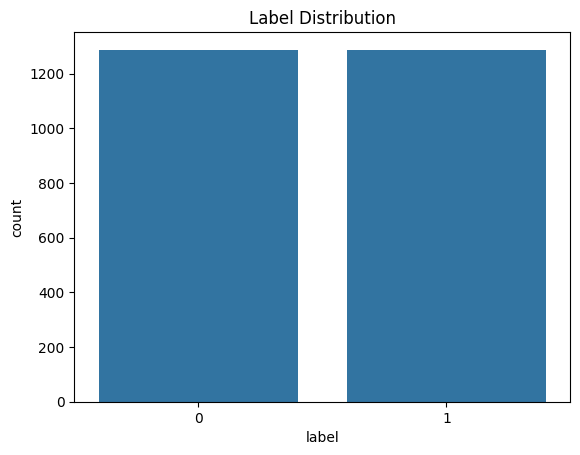

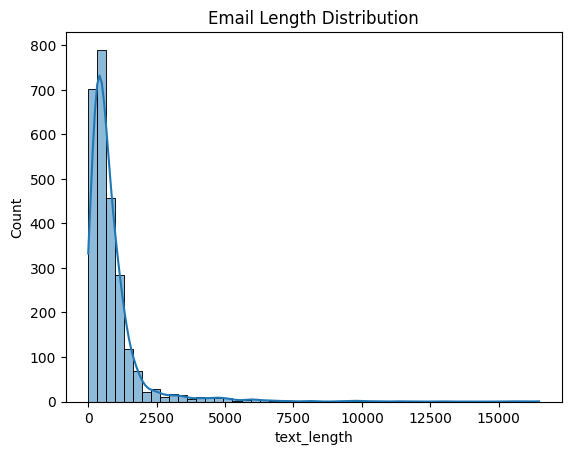

In [2]:
# Step 1: Load CSV with proper encoding (try utf-8 first, fallback to ISO-8859-1)

phishing_df = pd.read_csv('/content/CaptstoneProjectData_2025.csv')


# Step 2: Drop extra unnamed columns if present
phishing_df = phishing_df.loc[:, ['Subject', 'Body']]

# Step 3: Combine subject + body into one column for NLP
phishing_df['text_combined'] = phishing_df['Subject'].fillna('') + ' ' + phishing_df['Body'].fillna('')

# Step 4: TEMPORARY: Assign dummy labels (replace with real labels if available)
phishing_df['label'] = [0] * (len(phishing_df)//2) + [1] * (len(phishing_df) - len(phishing_df)//2)

# Step 5: Explore structure
print("Loaded phishing dataset with shape:", phishing_df.shape)
print("Columns:", phishing_df.columns.tolist())
print(phishing_df.head())
print(phishing_df['label'].value_counts())
print(phishing_df.isnull().sum())

# Step 6: Visualizations
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='label', data=phishing_df)
plt.title("Label Distribution")
plt.show()

phishing_df['text_length'] = phishing_df['text_combined'].apply(len)
sns.histplot(phishing_df['text_length'], bins=50, kde=True)
plt.title("Email Length Distribution")
plt.show()



3. Preprocessing Function

In [3]:
def drop_dates(text):
    text = text.lower()
    text = re.sub(r'http[s]?://\\S+', ' ', text)
    text = re.sub(r'\\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\\.[A-Z|a-z]{2,}\\b', ' ', text)
    patterns = [
        r'\\b(?:jan|feb|mar|apr|may|jun|jul|aug|sep|oct|nov|dec)[a-z]*\\s+\\d{1,4}\\b',
        r'\\b\\d{1,2}[\\/\\-]\\d{1,2}[\\/\\-]\\d{2,4}\\b',
        r'\\b\\d{4}\\-[01]\\d\\-[0-3]\\d\\b',
        r'\\b\\d{1,4}\\b'
    ]
    for p in patterns:
        text = re.sub(p, ' ', text, flags=re.IGNORECASE)
    return text


4. Train/Test Split and Cleaning

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    phishing_df['text_combined'], phishing_df['label'],
    test_size=0.3, random_state=42
)

X_train_clean = X_train.apply(drop_dates)
X_test_clean = X_test.apply(drop_dates)


5. Show Cleaning Samples

In [5]:
print("\n--- Sample Cleaning Output ---")
for i in range(3):
    original = X_train.iloc[i]
    cleaned = X_train_clean.iloc[i]
    print(f"\n--- Sample {i+1} ---")
    print("Original:", original[:300])
    print("Cleaned: ", cleaned[:300])



--- Sample Cleaning Output ---

--- Sample 1 ---
Original: ITS Help-desk Hello user,

This is the last and final notice or our administrator will disable your access to your email.

Please click here to University of Victoria<https://www.cognitoforms.com/Owanoffp/universityofvictoria> your account security by completing the required details to avoid the
Cleaned:  its help-desk hello user,

this is the last and final notice or our administrator will disable your access to your email.

please click here to university of victoria<https://www.cognitoforms.com/owanoffp/universityofvictoria> your account security by completing the required details to avoid the

--- Sample 2 ---
Original: Re:CHRISTMAS LOAN OFFER 3% ONLY PER MONTH --
Contact us for Christmas loan or any kind of loan with your full
details at: 3% per month. Whats-app Number: +1-434-217-1446

Brent Paul

Cleaned:  re:christmas loan offer 3% only per month --
contact us for christmas loan or any kind of loan with your full
detai

6. TF-IDF + Naive Bayes

In [6]:
tfidf_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('nb', MultinomialNB())
])

param_grid_tfidf = {
    'tfidf__max_features': [1000],
    'tfidf__ngram_range': [(1, 2)],
    'tfidf__min_df': [5],
    'tfidf__max_df': [0.9],
    'nb__alpha': [1.0]
}

gs_tfidf = GridSearchCV(tfidf_pipeline, param_grid_tfidf, cv=5, scoring='accuracy', n_jobs=-1)
gs_tfidf.fit(X_train_clean, y_train)

y_pred_tfidf = gs_tfidf.predict(X_test_clean)
y_prob_tfidf = gs_tfidf.predict_proba(X_test_clean)[:, 1]
acc_tfidf = accuracy_score(y_test, y_pred_tfidf)


7. BoW + Naive Bayes

In [7]:
bow_pipeline = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('classifier', MultinomialNB())
])

param_grid_bow = {
    'vectorizer__max_features': [5000],
    'vectorizer__ngram_range': [(1, 2)],
    'vectorizer__min_df': [5],
    'vectorizer__max_df': [0.9],
    'classifier__alpha': [1.0]
}

gs_bow = GridSearchCV(bow_pipeline, param_grid_bow, cv=5, scoring='accuracy', n_jobs=-1)
gs_bow.fit(X_train_clean, y_train)

y_pred_bow = gs_bow.predict(X_test_clean)
y_prob_bow = gs_bow.predict_proba(X_test_clean)[:, 1]
acc_bow = accuracy_score(y_test, y_pred_bow)


8. Summary + Confusion Matrix


Model Performance Comparison:
TF-IDF + Naive Bayes Accuracy: 0.7063
BoW + Naive Bayes Accuracy: 0.7374


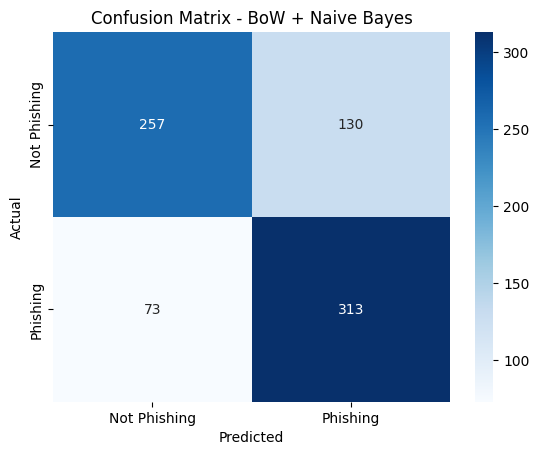

In [9]:
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Print accuracy summary
print("\nModel Performance Comparison:")
print(f"TF-IDF + Naive Bayes Accuracy: {acc_tfidf:.4f}")
print(f"BoW + Naive Bayes Accuracy: {acc_bow:.4f}")

# Plot confusion matrix for one of them (e.g., BoW)
cm = confusion_matrix(y_test, y_pred_bow)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Phishing', 'Phishing'],
            yticklabels=['Not Phishing', 'Phishing'])
plt.title("Confusion Matrix - BoW + Naive Bayes")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()



**Discussion:**

False Positive (FP = 130) → flagged legitimate email as phishing.

False Negative (FN = 73) → missed actual phishing emails.

This is especially dangerous.

**Why performance is low:**

Bag of Words / TF-IDF are weak: They don’t understand language, only word frequency.

Naive Bayes is simple: Assumes word independence; doesn’t model context.

No semantic features: models not leveraging context/meaning like BERT embeddings.

No optimization: No hyperparameter tuning, balancing, or feature engineering.

**Next Step:**

Use BERT Embeddings (with Logistic Regression or XGBoost)

Add Class Weighting or SMOTE

